In [26]:
# open csv with pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\marco\Documents\AFC\Diffusion-Models-for-Time-Series\data\real_orders.csv',header=0)
df_ = pd.read_csv(r'C:\Users\marco\Documents\AFC\Diffusion-Models-for-Time-Series\data\generated_orders.csv',header=0)   

In [27]:
class PCA2D(torch.nn.Module):
    def __init__(self, n_components=2):
        super(PCA2D, self).__init__()
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)

    def forward(self, x):
        x = x.values
        x = torch.Tensor(x)
        x = self.pca.fit_transform(x)
        return x

In [29]:
def preprocess_data(df):

    df = df[['PRICE', 'SIZE', 'TYPE', 'BUY_SELL_FLAG', 'ask_price_1', 'ask_size_1', 'bid_price_1', 'bid_size_1']]

    # Standardization on price and size
    df['PRICE'] = (df['PRICE'] - df['PRICE'].mean())/df['PRICE'].std()
    df['SIZE'] = (df['SIZE'] - df['SIZE'].mean())/df['SIZE'].std()
    df['ask_price_1'] = (df['ask_price_1'] - df['ask_price_1'].mean())/df['ask_price_1'].std()
    df['ask_size_1'] = (df['ask_size_1'] - df['ask_size_1'].mean())/df['ask_size_1'].std()
    df['bid_price_1'] = (df['bid_price_1'] - df['bid_price_1'].mean())/df['bid_price_1'].std()
    df['bid_size_1'] = (df['bid_size_1'] - df['bid_size_1'].mean())/df['bid_size_1'].std()

    # One hot encoding for the feature direction
    df = pd.get_dummies(df, columns=['TYPE'])
    df = pd.get_dummies(df, columns=['BUY_SELL_FLAG'])

    return df

C:\Users\marco\AppData\Local\Temp\ipykernel_19992\982374557.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PRICE'] = (df['PRICE'] - df['PRICE'].mean())/df['PRICE'].std()
C:\Users\marco\AppData\Local\Temp\ipykernel_19992\982374557.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SIZE'] = (df['SIZE'] - df['SIZE'].mean())/df['SIZE'].std()
C:\Users\marco\AppData\Local\Temp\ipykernel_19992\982374557.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


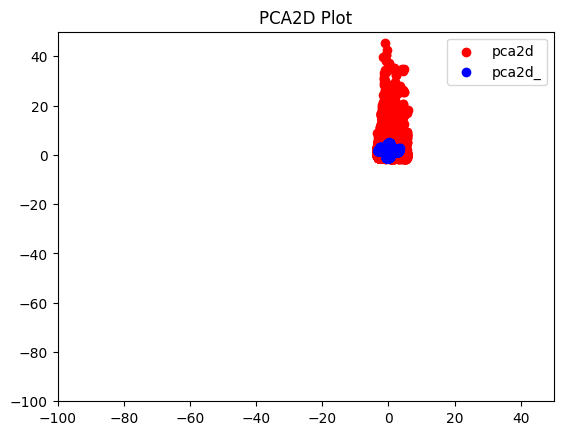

In [30]:
import matplotlib.pyplot as plt

def plot_data(pca2d, pca2d_):
    # Plot pca2d in red
    plt.scatter(pca2d[:, 0], pca2d[:, 1], color='red', label='real')

    # Plot pca2d_ in blue
    plt.scatter(pca2d_[:, 0], pca2d_[:, 1], color='blue', label='generated')

    # Limit x and y axes
    plt.xlim(-100, 50)
    plt.ylim(-100, 50)

    # Add legend and title
    plt.legend()
    plt.title('PCA2D Plot')

    # Show the plot
    plt.show()

df = preprocess_data(df)
df_ = preprocess_data(df_)

pca2d = PCA2D(n_components=2).forward(df)
pca2d_ = PCA2D(n_components=2).forward(df_)

plot_data(pca2d, pca2d_)